In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/rossmann-store-sales/sample_submission.csv
/kaggle/input/rossmann-store-sales/store.csv
/kaggle/input/rossmann-store-sales/train.csv
/kaggle/input/rossmann-store-sales/test.csv


# Installing Prophet Library

We need to install the prophet library before using it. Prophet library helps us to forecast future sales prediction.

In [2]:
pip install prophet

Note: you may need to restart the kernel to use updated packages.


# Importing Libraries

In this section, we import important libraries. 

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import plotly.express as px
from prophet import Prophet
import warnings 
warnings.filterwarnings('ignore')

# Data Information

Reading csv files

In [4]:
store=pd.read_csv('/kaggle/input/rossmann-store-sales/store.csv')
train=pd.read_csv('/kaggle/input/rossmann-store-sales/train.csv')
test=pd.read_csv('/kaggle/input/rossmann-store-sales/test.csv')
submission=pd.read_csv('/kaggle/input/rossmann-store-sales/sample_submission.csv')

In [5]:
train.shape

(1017209, 9)

In [6]:
train.head(5)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


**Controlling null values**

In [7]:
train.isnull().sum()

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

there isn't null values in train data

In [8]:
test.isnull().sum()

Id                0
Store             0
DayOfWeek         0
Date              0
Open             11
Promo             0
StateHoliday      0
SchoolHoliday     0
dtype: int64

there are 11 null values in Open column.

In [9]:
store.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In store data, there are many null values. We need to drop these values or add new value in order to fix this problem.

In [10]:
store.head(5)

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


We need to fill nan or null values in data

In [11]:
store['CompetitionDistance'].fillna(store['CompetitionDistance'].median(), inplace = True)

In [12]:
store.fillna(0, inplace = True)

In [13]:
store.isnull().sum()

Store                        0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64

**Checking Duplicated Values**

In [14]:
train.duplicated().sum()

0

In [15]:
test.duplicated().sum()

0

In [16]:
store.duplicated().sum()

0

No duplicated values are in three data.

**Statistical Information**

In [17]:
train.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
mean,5.584297e+02,3.998341e+00,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01
std,3.219087e+02,1.997391e+00,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.800000e+02,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00
50%,5.580000e+02,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00
75%,8.380000e+02,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00
max,1.115000e+03,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00


In [18]:
test.describe()

,Id,Store,DayOfWeek,Open,Promo,SchoolHoliday
count,41088.000000,41088.000000,41088.000000,41077.000000,41088.000000,41088.000000
mean,20544.500000,555.899533,3.979167,0.854322,0.395833,0.443487
std,11861.228267,320.274496,2.015481,0.352787,0.489035,0.496802
min,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,10272.750000,279.750000,2.000000,1.000000,0.000000,0.000000
50%,20544.500000,553.500000,4.000000,1.000000,0.000000,0.000000
75%,30816.250000,832.250000,6.000000,1.000000,1.000000,1.000000
max,41088.000000,1115.000000,7.000000,1.000000,1.000000,1.000000


In [19]:
store.describe()

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,1115.00000,1115.000000,1115.000000,1115.000000,1115.000000,1115.000000,1115.000000
mean,558.00000,5396.614350,4.930942,1370.939013,0.512108,12.083408,1030.239462
std,322.01708,7654.513635,4.284924,935.467654,0.500078,15.542241,1006.038782
min,1.00000,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,279.50000,720.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,558.00000,2325.000000,4.000000,2006.000000,1.000000,1.000000,2009.000000
75%,836.50000,6875.000000,9.000000,2011.000000,1.000000,22.000000,2012.000000
max,1115.00000,75860.000000,12.000000,2015.000000,1.000000,50.000000,2015.000000


**Combining train/test and store data**

In [20]:
train = pd.merge(train, store, how = 'left', on = 'Store')
test = pd.merge(test, store, how = 'left', on = 'Store')

# Feature Extraction

In [21]:
train['year'] = pd.to_datetime(train['Date'], errors='coerce').dt.year
train[['Date','year']][:5]

,Date,year
0,2015-07-31,2015
1,2015-07-31,2015
2,2015-07-31,2015
3,2015-07-31,2015
4,2015-07-31,2015


In [22]:
train['month'] = pd.to_datetime(train['Date'], errors='coerce').dt.month
train[['Date','month']][:5]

,Date,month
0,2015-07-31,7
1,2015-07-31,7
2,2015-07-31,7
3,2015-07-31,7
4,2015-07-31,7


In [23]:
train['day'] = pd.to_datetime(train['Date'], errors='coerce').dt.day
train[['Date','day']][:5]

,Date,day
0,2015-07-31,31
1,2015-07-31,31
2,2015-07-31,31
3,2015-07-31,31
4,2015-07-31,31


In [24]:
train['weekday'] =pd.to_datetime(train['Date'],errors='coerce').dt.strftime('%A')  
train[['Date','weekday']].sample(5)

,Date,weekday
648557,2013-11-27,Wednesday
943222,2013-03-08,Friday
616284,2013-12-26,Thursday
511957,2014-03-30,Sunday
327608,2014-09-25,Thursday


# Exloratory Data Analysis

**How many open or closed stores are in the data?**

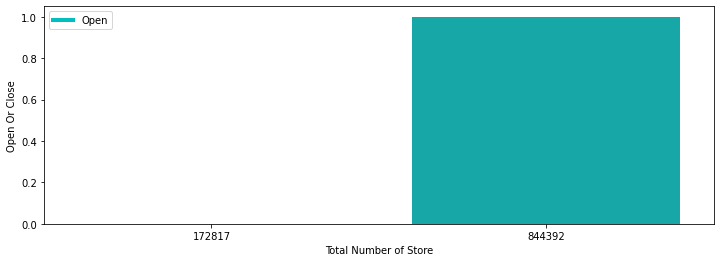

In [25]:
fig_dims = (12, 4)
fig, ax = plt.subplots(figsize=fig_dims)
x=train.groupby(['Open'])[['Store']].count()
x=x.reset_index()
labels=['Open','Closed']
sns.barplot(x['Store'],x['Open'],color='c')
plt.xlabel('Total Number of Store')
plt.ylabel('Open Or Close')
legend_elements = [Line2D([0], [0], color='c', lw=4, label='Open')]
plt.legend(handles=legend_elements);
plt.show()


In above figure, there are 172817 closed stores and there are 844392 open stores.

**How many Promo is in the data?**

<bound method Series.unique of 0    629129
1    388080
Name: Promo, dtype: int64>

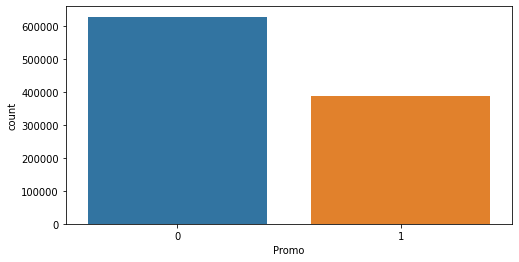

In [26]:
fig_dims = (8, 4)
fig, ax = plt.subplots(figsize=fig_dims)
sns.countplot(train['Promo'])
train['Promo'].value_counts().unique

there are 629129 no promotions, and there are 388080 promotions in the data

**Which day has the most Customers?**

<AxesSubplot:xlabel='weekday'>

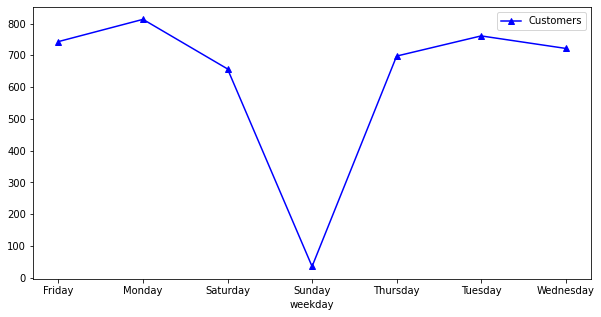

In [27]:
train.groupby('weekday')[['Customers']].mean().sort_index().plot(figsize = (10,5), marker = '^', color = 'b')

The weekday Monday has the highest customer number in the store. 

The weekday of Sunday hasn't customers because of the holiday. 

The lowest customer number is on the weekend of Saturday. 

Also, in the below code snippet, we can see this result using the 'DayOfWeek' column.

<AxesSubplot:xlabel='DayOfWeek'>

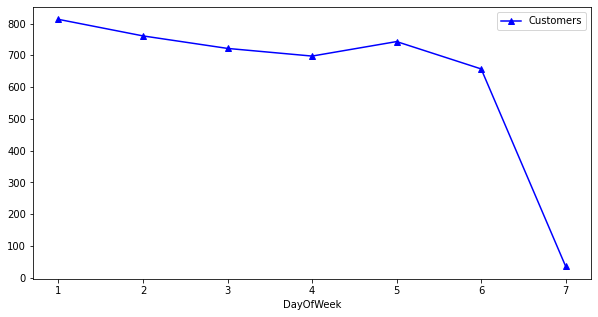

In [28]:
train.groupby('DayOfWeek')[['Customers']].mean().plot(figsize = (10,5), marker = '^', color = 'b')

DayOfWeek is from Monday to Sunday e.g. 1 is Monday, 2 is Tuesday, and 3 is Wednesday

**Which day has the Promotion?**

<AxesSubplot:xlabel='weekday', ylabel='count'>

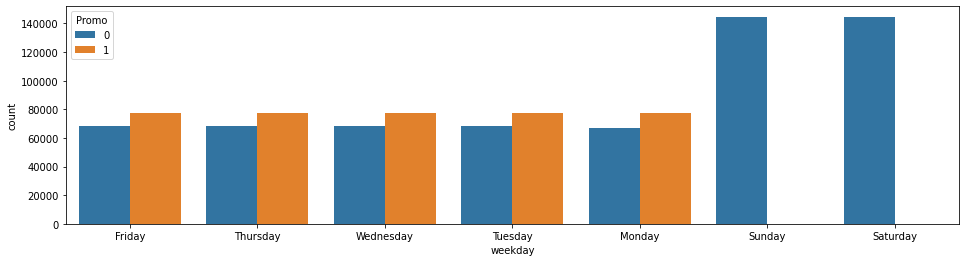

In [29]:
fig_dims = (16, 4)
fig, ax = plt.subplots(figsize=fig_dims)
sns.countplot(x='weekday',hue='Promo',data=train)


In the above figure, all of the weekday has a promotion. The weekend has no promotion.

**Which store has the highest Sales Price?**

In [30]:
x=train.groupby('Store')[['Sales']].mean()
fig=px.line(x,x=x.index,y='Sales',title='Average Store Sales',markers=True)
fig.show()

We can clearly see that the store which is the number of 262 has the highest sales price compared to other stores.

**Which store has the more Customers?**

Text(0, 0.5, ' Max Customer Number')

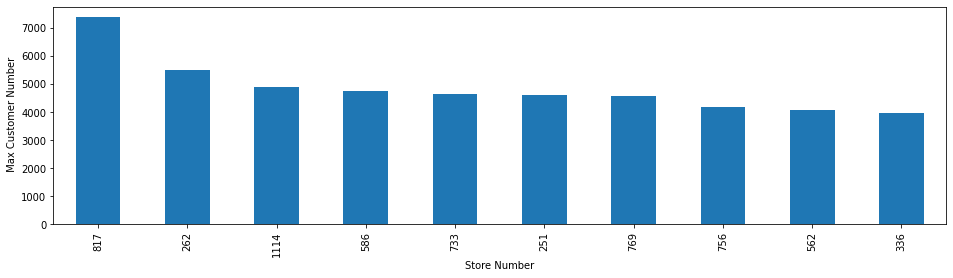

In [31]:
fig_dims = (16, 4)
fig, ax = plt.subplots(figsize=fig_dims)

train.groupby('Store').agg({'Customers': 'max'})['Customers'].nlargest(10).plot.bar()
plt.xlabel('Store Number')
plt.ylabel(' Max Customer Number')

In the figure, the store which is 817 number has the maximum number of customers. Other stores follow it

**Does Store which has the highest sales have more customers?**

When we look at above 2 figures, we can say that the store which has the highest sales price has more customers than the other stores. This is the expected result for us.

**Which year has the highest sales price?**

Text(0, 0.5, 'Sales')

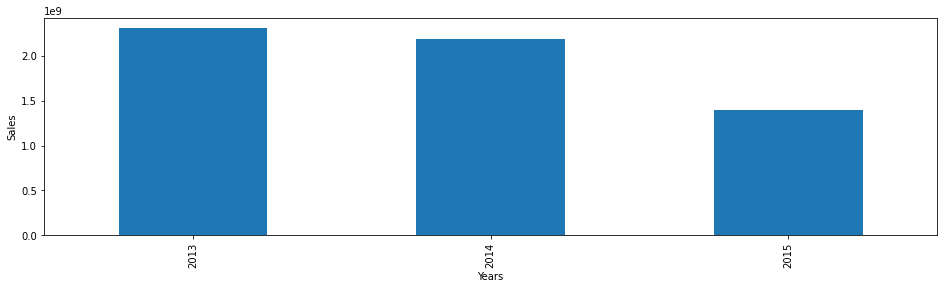

In [32]:
fig_dims = (16, 4)
fig, ax = plt.subplots(figsize=fig_dims)
train.groupby('year').agg({'Sales': 'sum'})['Sales'].nlargest(10).plot.bar()
plt.xlabel('Years')
plt.ylabel('Sales')

2013 has the highest sales price compared to the two years.

**Which year has the highest customer number?**

Text(0, 0.5, 'Customers')

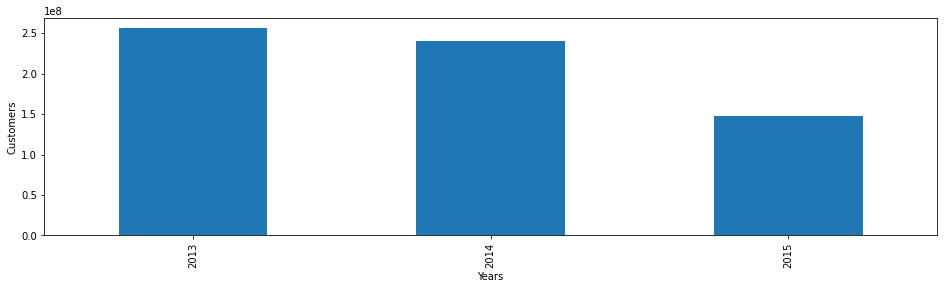

In [33]:
fig_dims = (16, 4)
fig, ax = plt.subplots(figsize=fig_dims)
train.groupby('year').agg({'Customers': 'sum'})['Customers'].nlargest(10).plot.bar()
plt.xlabel('Years')
plt.ylabel('Customers')

The year of 2013 has the highest customers compared to 2014 and 2015. 2015 has the lowest customers. 


**Which month has the highest sales price?**

In [34]:

x=train.groupby('month')[['Sales']].mean()
fig=px.line(x,x=x.index,y='Sales', title = 'Average Monthly Sales Price', markers = True)
fig.show()


December, November,and July moths have 3  the highest sales price.

Januvary, May, and October have the lowest sales price.

**Which month has the highest number of Customers?**

In [35]:
x=train.groupby('month')[['Customers']].mean()
fig=px.line(x,x=x.index,y='Customers',title='Average Monthly Customer Number',markers=True)
fig.show()

12th month has the highest customer number that the average customer number  is 703.06. 

**Which day has the highest sales price?**

In [36]:
x=train.groupby('day')[['Sales']].mean()
fig=px.line(x,x=x.index,y='Sales',title='Average Daily Sales Price',markers=True)
fig.show()

Although 1th day has the lowest sales price, the day of 30 has the highest sales price. 

**Which day the highest Customer number?**

In [37]:
x=train.groupby('day')[['Customers']].mean()
fig=px.line(x,x=x.index,y='Customers',title='Average Daily Customer Number',markers=True)
fig.show()

We can clearly see that Customer and Sales price has the right proportion. The first day has the lowest price. On the contrary, the 30th day has the highest sales price. This is the expected result from our point of view. How many customers increase that many sales increase

**Does Promotion effect the Sales Price?**

[]

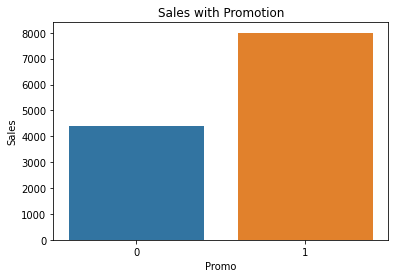

In [38]:

sns.barplot(x='Promo',y='Sales',data=train)
plt.title('Sales with Promotion')
plt.plot()


In above figure, 0 represents no promotion and 1 represents promotion.The sales price has the highest when there is a promotion. 

**Monthly Distribution of Sales Price and Promotion**

Text(0.5, 1.0, 'Monthly Distribution Sales Price and Promotion')

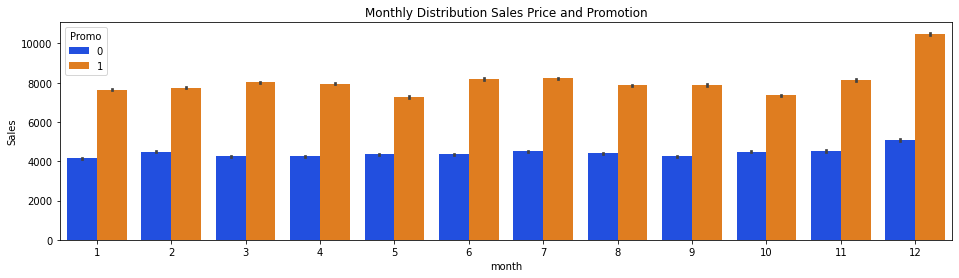

In [39]:
fig_dims = (16, 4)
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(
    x='month', 
    y='Sales', 
    data=train, 
    palette='bright',
    hue='Promo');
plt.title('Monthly Distribution Sales Price and Promotion')


When we look at month by month, promotion increases sales prices and it affects the sales strategy. The 12th month with promotion has the highest sales price compared with other months.

**State Holidays and Sales**

Text(0.5, 1.0, 'State Holidays and Sales')

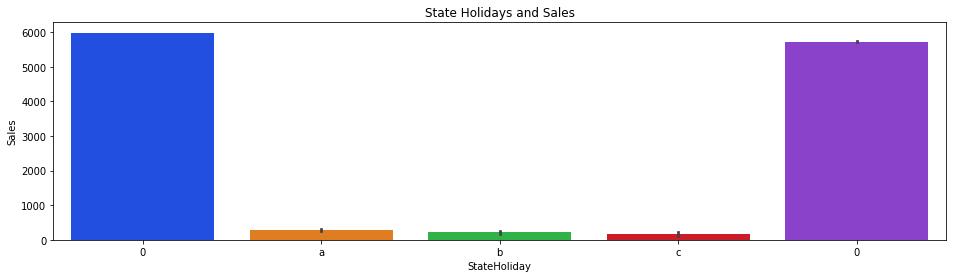

In [40]:
fig_dims = (16, 4)
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(
    x='StateHoliday', 
    y='Sales', 
    data=train, 
    palette='bright',
   );
plt.title('State Holidays and Sales')

There are no sales during the public holiday period. Therefore, important holidays affect sales.

**Monthly Distribution of  Sales Price and School Holiday**

Text(0.5, 1.0, 'Monthly Distribution Sales Price and School Holiday')

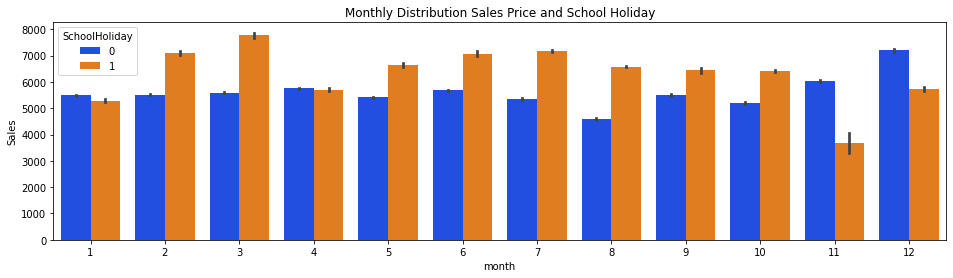

In [41]:
fig_dims = (16, 4)
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(
    x='month', 
    y='Sales', 
    data=train, 
    palette='bright',
    hue='SchoolHoliday');
plt.title('Monthly Distribution Sales Price and School Holiday')

When the school is open, the maximum sales price is in the third month and the minimum sales price is in November which is the 11th month. 
When the school is close, the maximum sales price is in December and  the lowest sales price is in the August.

**Sales Vs Store Types,  Customers Vs Store Types**

<AxesSubplot:xlabel='StoreType', ylabel='Customers'>

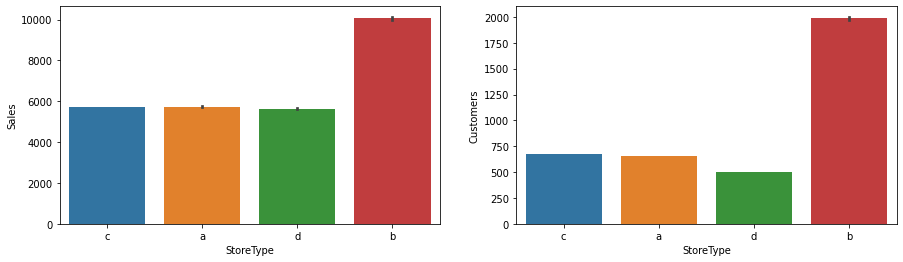

In [42]:
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))
sns.barplot(x=train['StoreType'],y=train['Sales'], ax=axis1)
sns.barplot(x=train['StoreType'],y=train['Customers'], ax=axis2)


In the left figure, the b store has the highest sales. a, c, d stores have the same sales prices approximately. When we look at the right figure, b has the highest number of customers with a clear difference. In this figure, only the d store has the lowest number of customers but it has the same sales prices compared to a and c stores.

**Sales Vs State Holidays**

<AxesSubplot:xlabel='StateHoliday', ylabel='Customers'>

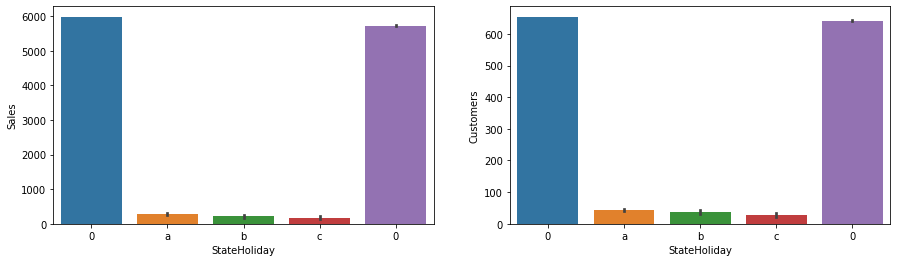

In [43]:
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))
sns.barplot(x=train['StateHoliday'],y=train['Sales'], ax=axis1)
sns.barplot(x=train['StateHoliday'],y=train['Customers'], ax=axis2)

In the left and right figures, a, b, and c show the state holidays. These days, there aren't sales and customers. There are many sales in normal days. 

**Sales Vs School Holidays**

<AxesSubplot:xlabel='SchoolHoliday', ylabel='Customers'>

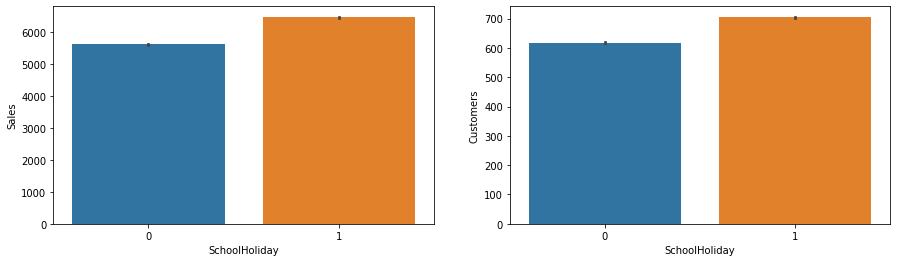

In [44]:
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))
sns.barplot(x=train['SchoolHoliday'],y=train['Sales'], ax=axis1)
sns.barplot(x=train['SchoolHoliday'],y=train['Customers'], ax=axis2)

When we look at the two figures, O shows the no school holidays and 1 shows the school holidays. we can clearly see that the school holiday increases the sales price and customers proportionally.

# Feature Engineering

Before we start estimating, we need to clean up the data. Our data has some types of objects. Each string and month value is converted to an integer type so that it can become more meaningful data.

In [45]:
def clean_data(data):
    
    label1 = {'0':0, 'a':1, 'b':2, 'c':3, 'd':4}
    label2 = {'0':0, 'Jan,Apr,Jul,Oct':1, 'Feb,May,Aug,Nov':2, 'Mar,Jun,Sept,Dec':3}
    data.StoreType.replace(label1, inplace=True)
    data.Assortment.replace(label1, inplace=True)
    data.StateHoliday.replace(label1, inplace=True)
    data.PromoInterval.replace(label2, inplace=True)
    data['StoreType'] = data['StoreType'].astype(int)
    data['Assortment'] = data['Assortment'].astype(int)
    data['StateHoliday'] = data['StateHoliday'].astype(int)
    data['PromoInterval'] = data['PromoInterval'].astype(int)
    
    return data

In [46]:
train=clean_data(train)
test=clean_data(test)

Closed stores and days which didn't have any sales won't be counted into the forecasts

In [47]:
train = train[(train["Open"] != 0) & (train['Sales'] != 0)]

**Correlation Analysis**

Correlation analysis shows the relationship between 2 features. This analysis helps us to understand which features are positive or negative relationships.

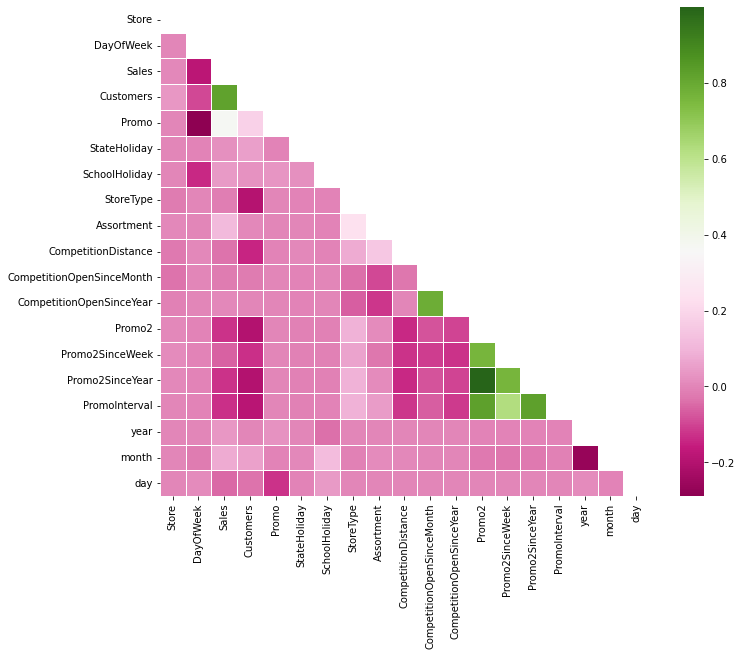

In [48]:
# Compute the correlation matrix 
# exclude 'Open' variable
corr_all = train.drop('Open', axis = 1).corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr_all, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize = (11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_all, mask = mask,
            square = True, linewidths = .5, ax = ax, cmap = "PiYG")      
plt.show()

In the above figure, the heat map shows the relationship between two features. Each two features values must be between -1 and 1. When we explain the map: 

**-1** means that there is a negative relationship between 2 features. For example, Customers and PromoInterval have a negative relationship. The colour of the value is light blue. 

**0** means that there is no relationship between 2 features.

**1** means that there is a positive relationship between 2 features. For example, Promo2 and Promo2SinceYear have a strong positive relationship.

# Sales Forecasting using Prophet

We will use the Prophet library for predicting future values. Before using this library, we need to import it. Use the below code snippets to download the library:

* pip install prophet
* from prophet import Prophet

Now, we are ready to work on this library. 

* The Prophet() object takes arguments to configure the type of model you want, such as the type of growth, the type of seasonality, and more.

* The fit() function takes a DataFrame for date time stamp. The DataFrame must have a specific format. The first column must have the name ‘ds‘ and contain the date-times. The second column must have the name ‘y‘ and contain the samples. In our project, ds is also Date column and y is Sales column. We try to find future sales values.For this reason, our observations/samples is Sales values. 

Before using the Prophet module, we need to edit our data frame.

1. We are forcasting for first store so we select the first store from data frame

In [49]:
sales = train[train.Store == 1].loc[:, ['Date', 'Sales']]

2. We convert data frame to specific format. Date column converts ds(starting date) and Sales column converts y(sales samples)

In [50]:
df = sales[['Date', 'Sales']].rename(columns = {'Date': 'ds', 'Sales': 'y'})

3. We sort data frames in ascending order

In [51]:
df=df.sort_values(by='ds')

4. We create the first Prophet model using the default parameters

In [52]:
model = Prophet()

5. Now that our Prophet model has been initialized, we can call its fit method with our DataFrame as input.

In [53]:
model.fit(df)

23:52:35 - cmdstanpy - INFO - Chain [1] start processing
23:52:35 - cmdstanpy - INFO - Chain [1] done processing


6. We create a new DataFrame containing a ds column that holds the dates for which we want predictions.

'make_future_dataframe' function helps us to this purpose.
In the code snippet below, we determined Prophet to generate 42 datestamps in the future. 
We are working the weekly data, we generated 6 weeks timestamp. If you want to change timestamp for weekly, you can generate your own timestamp.

In [54]:
future = model.make_future_dataframe(periods = 42,freq='W')
future.head()

,ds
0,2013-01-02
1,2013-01-03
2,2013-01-04
3,2013-01-05
4,2013-01-07


Now,we can predict our model

In [55]:
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
818,2016-04-17,4662.251977,3635.256881,5797.760986
819,2016-04-24,4711.747577,3674.750006,5858.783698
820,2016-05-01,4831.276429,3761.181652,5889.146591
821,2016-05-08,4902.302350,3814.695194,5999.175217
822,2016-05-15,4852.640001,3809.576941,5995.328956


There are 4 outputs that are important to explain. These outputs are:

**ds:** the datestamp of the forecasted value

**yhat:** the forecasted value of our metric

**yhat_lower:** the lower bound of our forecasts

**yhat_upper:** the upper bound of our forecasts

Prophet provides a plot function to show the results quickly

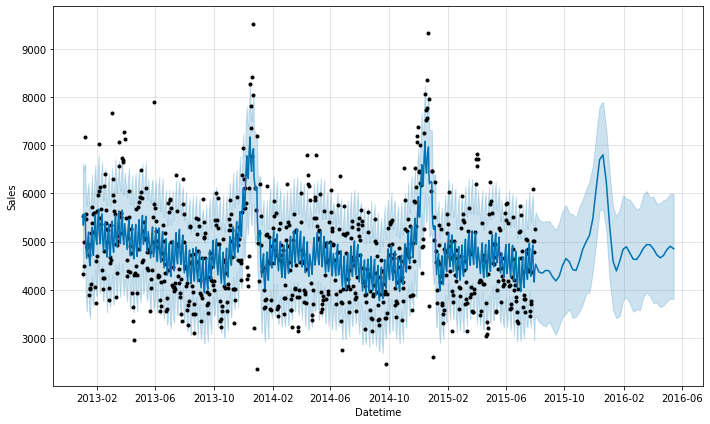

In [56]:
 fig1=model.plot(forecast,xlabel='Datetime',ylabel='Sales',uncertainty=True)


ın above, two figures shows the observed values of our sales price prediction (the black dots), the forecasted values (blue line) and the uncertainty intervals of our forecasts (the light blue shaded regions).

Prophet library provides to return the components of our forecasts.

This can help reveal how daily, weekly and yearly patterns of the time series contribute to the overall forecasted values.

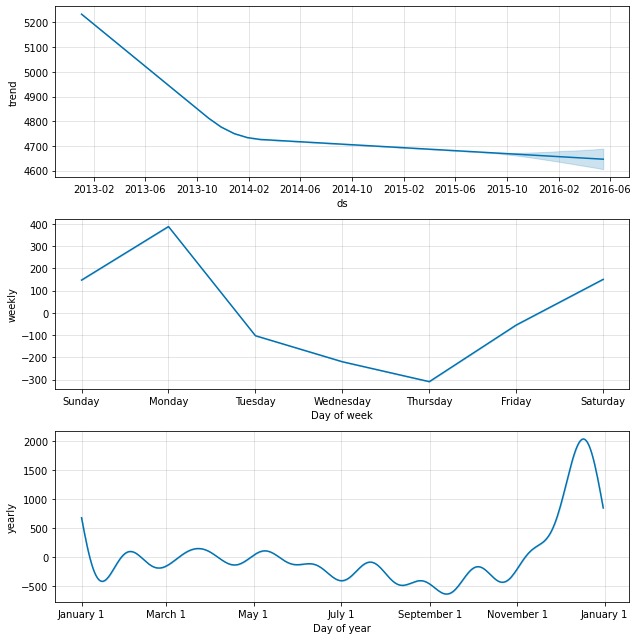

In [57]:
fig2=model.plot_components(forecast)


The above plot provides interesting insights.

The first plot shows that the monthly volume of sales has been linearly decreasing over time.

The second plot highlights the fact that the weekly count of sales highly increases on the week of Monday.

The third plot shows that the most sales occur during the months of December.

**Modelling Holidays**

Now, we add holiday to our model.

In [58]:
# create holidays dataframe
#Three different holidays are avaiable in State Holiday
state_dates = train[(train.StateHoliday == 'a') | (train.StateHoliday == 'b') & (train.StateHoliday == 'c')].loc[:, 'Date'].values
school_dates = train[train.SchoolHoliday == 1].loc[:, 'Date'].values

state = pd.DataFrame({'holiday': 'state_holiday',
                      'ds': pd.to_datetime(state_dates)})
school = pd.DataFrame({'holiday': 'school_holiday',
                      'ds': pd.to_datetime(school_dates)})

holidays = pd.concat((state, school))      
holidays.head(5)

,holiday,ds
0,school_holiday,2015-07-31
1,school_holiday,2015-07-31
2,school_holiday,2015-07-31
3,school_holiday,2015-07-31
4,school_holiday,2015-07-31


In [59]:

model = Prophet(interval_width=0.95, holidays = holidays)
model.fit(df)

# dataframe that extends into future 6 weeks 
future_dates = model.make_future_dataframe(periods = 42)

print("First week to forecast.")
future_dates.tail(7)

23:53:04 - cmdstanpy - INFO - Chain [1] start processing
23:53:04 - cmdstanpy - INFO - Chain [1] done processing


First week to forecast.


,ds
816,2015-09-05
817,2015-09-06
818,2015-09-07
819,2015-09-08
820,2015-09-09
821,2015-09-10
822,2015-09-11


In [60]:
forecast = model.predict(future_dates)

# preditions for last week
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
816,2015-09-05,4087.859442,2469.014664,5763.876338
817,2015-09-06,4075.491749,2362.093367,5677.062018
818,2015-09-07,4156.978299,2516.141334,5855.174580
819,2015-09-08,3660.767435,2018.264356,5222.933614
820,2015-09-09,3545.312514,1951.546253,5168.271274
821,2015-09-10,3466.842591,1878.400828,5172.665141
822,2015-09-11,3723.137968,2219.758655,5377.343769


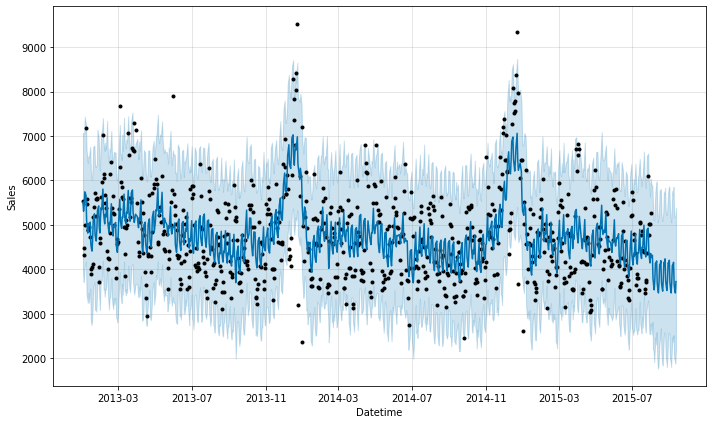

In [61]:
fig3=model.plot(forecast,xlabel='Datetime',ylabel='Sales',uncertainty=True);

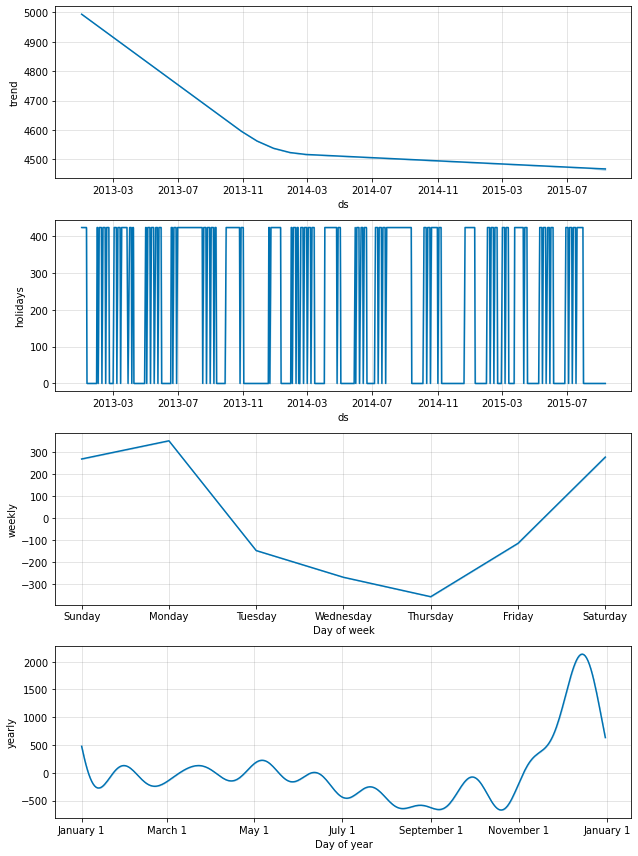

In [62]:
fig2=model.plot_components(forecast)

**Explanation of 4 plots:**

The first plot fact is that the trend is clearly downwards over time

The second plot shows that  the holidays' gaps include in the model

The third plot demonstrates that Sales peaks on Monday, and hit bottom on Tuesday

The last plot shows that the busiest working period is in December which is during the Christmas holidays.

# Conclusion

* We applied preprocessing and feature engineering technique

* We visualized data and interpreted it

* We used the Prophet library to perform sales forecasting in Python





We come to the end of this notebook.

I hope you find this notebook useful.

Your comments and feedback are crucial for me, 
you can share your comments with me. 

Thank you 